# Simplified models

In this tutorial, you will learn how to:

- use `Jaxley` to simulate simplified neuron models such as:  
  - Leaky-integrate-and-fire neuron models 
  - Izhikevich neuron models
  - Rate-based neuron models (unit-free)  
- define your own simplified neuron models  

Here is a code snippet which you will learn to understand in this tutorial:
```python
# Leaky integrate-and-fire neurons.
from jaxley.channels import Leak, Fire
cell = jx.Cell()
cell.insert(Leak())
cell.insert(Fire())
cell.record("v")
cell.record("Fire_spikes")

# Izhikevich neuron models.
from jaxley.channels import Izhikevich
cell = jx.Cell()
cell.insert(Izhikevich())
cell.record("v")

# Rate-based neuron models (unit-free).
from jaxley.channels import Rate
cell = jx.Cell()
cell.set("length", 1.0 / (2 * pi * 1e-5))  # Make external current and synapses unit-free.
cell.insert(Rate())
cell.record("v")
```

`Jaxley` focuses on biophysical, Hodgkin-Huxley-type models. These models follow the equation

$$
\frac{1}{C} \frac{\text{d}V}{\text{d}t} = i,
$$

where $C$ is the capacitance, $V$ is the membrane voltage, and $i$ is a membrane current which is linear in the voltage, for example $i=g_{\text{Leak}} (E_{\text{Leak}} - V)$. All Hodkgin-Huxley-type models fall into this category, but many simplified neuron models do not follow these equations. Nonetheless, `Jaxley` can also simulate such simpler neuron models. This tutorial will teach you how to do this.

In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

import jaxley as jx

## Pre-configured simplified models

We will first go over three popular, pre-configured neuron models (LIF, Izhikevich, rate-based).

### Leaky integrate-and-fire neuron models

Leaky integrate-and-fire (LIF) neurons follow the equation:

$$
\frac{1}{C} \frac{\text{d}V}{\text{d}t} = g_{\text{Leak}} (E_{\text{Leak}} - V),
$$

with the reset condition:

$$
\text{if } V \geq 30 \text{ mV, then } 
V \leftarrow V_{\text{reset}} \\
$$

The first equation is consistent with the Hodgkin-Huxley mechanism (with only a leak channel), but the reset is not. To implement LIF neurons, run:

In [2]:
from jaxley.channels import Leak, Fire
cell = jx.Cell()
cell.insert(Leak())
cell.insert(Fire())
cell.record("v")
cell.record("Fire_spikes")

Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


/Users/michaeldeistler/Documents/phd/jaxley/jaxley/channels/non_capacitive/spike.py:29: UserWarning: The `Fire` channel does not support surrogate gradients. Its gradient will be zero after every spike.
  warn(


Added 1 external_states. See `.externals` for details.


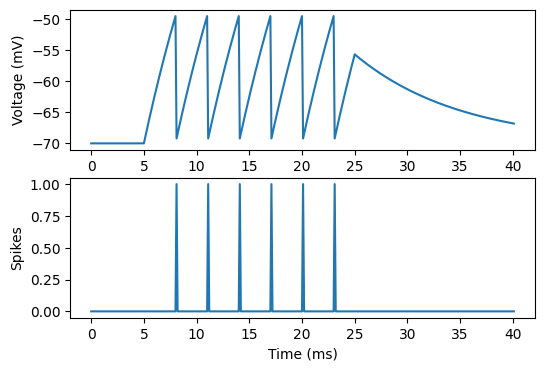

In [3]:
dt = 0.1
t_max = 40.0

cell.stimulate(jx.step_current(5.0, 20.0, 0.005, dt, t_max))
v = jx.integrate(cell, delta_t=dt)
time_vec = jnp.arange(0, t_max + 2 * dt, dt)
fig, ax = plt.subplots(2, 1, figsize=(6, 4))
_ = ax[0].plot(time_vec, v[0])
_ = ax[1].plot(time_vec, v[1])
_ = ax[0].set_ylabel("Voltage (mV)")
_ = ax[1].set_ylabel("Spikes")
_ = ax[1].set_xlabel("Time (ms)")

### Izhikevich neuron models

Finally, Izhikevich neuron models follow the equation:
    
$$
\frac{\text{d}V}{\text{d}t} = 0.04V^2 + 5V + 140 - u + I
$$

$$
\frac{\text{d}u}{\text{d}t} = a (bV - u)
$$

with the reset condition:

$$
\text{if } V \geq 30 \text{ mV, then } 
\begin{cases} 
V \leftarrow c \\
u \leftarrow u + d
\end{cases}
$$

The voltage is not consistent with the standard Hodgkin-Huxley equations because:
- it does not include a capacitance
- the update is not linear in the voltage ($0.04 V^2$)

To implement this equation in `Jaxley`, run:

In [4]:
from jaxley.channels import Izhikevich
cell = jx.Cell()
cell.insert(Izhikevich())
cell.record("v")

Added 1 recordings. See `.recordings` for details.


/Users/michaeldeistler/Documents/phd/jaxley/jaxley/channels/non_capacitive/izhikevich.py:28: UserWarning: The `Izhikevich` channel does not support surrogate gradients. Its gradient will be zero after every spike.
  warn(


Unlike for Integrate-and-Fire neurons, `Jaxley` does not yet support optimizing Izhikevich neuron models with gradient descent (because of the non-differentiable reset). However, one could implement a surrogate gradient for the reset to make gradient descent possible. For more information on surrogate gradients, see the `Fire` channel description and notes later in this tutorial.

For now, let's simulate the Izhikevich neuron:

Added 1 external_states. See `.externals` for details.


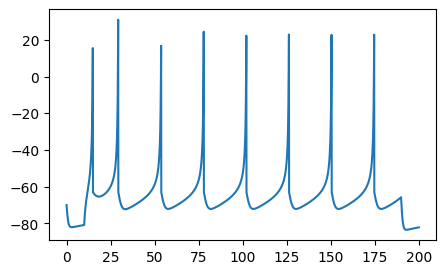

In [5]:
dt = 0.1
t_max = 200.0

cell.stimulate(jx.step_current(10.0, 180.0, 0.012, dt, t_max))
v = jx.integrate(cell, delta_t=dt)
time_vec = jnp.arange(0, t_max + 2 * dt, dt)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
_ = plt.plot(time_vec, v.T)

### Rate-based neuron models

Rate-based neuron models follow the equation

$$
\frac{1}{\tau} \frac{\text{d}V}{\text{d}t} = -V.
$$

A rate-based neuron model is, in principle, consistent with Hodgkin-Huxley equations, and it could be implemented with a `Leak` channel in `Jaxley`. However, rate-based neuron models are sometimes assumed to be _unit free_. To implement a _unit-free_ rate-based neuron model in `Jaxley`, use the `Rate` mechanism and define `radius` and `length` of the cell such that stimuli or synaptic inputs become unit free:

In [6]:
from jaxley.channels import Rate
from math import pi

cell = jx.Cell()
# If `length = 1 / (2 * pi * 1e-5) um` and `radius = 1.0um`, then `area = 1e5 um^2 = 1e-3 cm2`.
# The `1e-3` corrects for stimuli being in `nA`, but voltage updates being in `mV * ms = uA`.
# As such, setting `length = 1 / (2 * pi * 1e-5) um` and `radius = 1.0 um` effectively makes
# the external currents or synaptic currents unit-free.
cell.set("length", 1.0 / (2 * pi * 1e-5))
cell.set("radius", 1.0)  # 1.0 is also the default.
cell.insert(Rate())

Let's simulate this cell:

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.


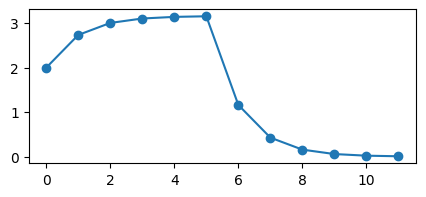

In [7]:
cell.stimulate(2.0 * jnp.ones((5,)))
cell.set("v", 2.0)
cell.record("v")

dt = 1.0
t_max = 10.0

v = jx.integrate(cell, t_max=t_max, delta_t=dt)
time_vec = jnp.arange(0, t_max + 2 * dt, dt)
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
_ = plt.plot(time_vec, v.T, marker="o")

The voltage increases during the the first 5 timesteps, because we are stimulating the cell during that time, and then quickly drops off to zero.

## How to implement your own simplified models

If the models above do not offer enough flexibility for your usecase, you can also implement mechanisms yourself. For this, it is helpful if you first read the tutorial on [how to build channel models in `Jaxley`](https://jaxley.readthedocs.io/en/latest/tutorials/05_channel_and_synapse_models.html).

As you learned in this tutorial, every channel returns a current in its `compute_current` method. This is the current that turns up on the right side of the Hodgkin-Huxley equation

$$
\frac{1}{C} \frac{\text{d}V}{\text{d}t} = i.
$$

If you specifically want to update voltages in a way that does not fall within this equation, you should instead update voltages in the `update_states()` method. Let's have a look at how the reset in a leaky integrate-and-fire neuron is implemented:

In [8]:
from jaxley.channels import Channel
from jaxley.solver_gate import heaviside


class Fire(Channel):
    """Mechanism to reset the voltage when it crosses a threshold."""

    def __init__(self, name = None):
        self.current_is_in_mA_per_cm2 = True
        super().__init__(name)
        self.channel_params = {f"{self.name}_vth": -50, f"{self.name}_vreset": -70}
        self.channel_states = {f"{self.name}_spikes": False}
        self.current_name = f"{self.name}_fire"

    def update_states(self, states, dt, v, params):
        """Reset the voltage when a spike occurs and log the spike"""
        prefix = self._name
        vreset = params[f"{prefix}_vreset"]
        vth = params[f"{prefix}_vth"]

        spike_occurred = heaviside(v - vth)
        v = (v * (1 - heaviside(v - vth))) + (vreset * heaviside(v - vth))

        return {"v": v, f"{self.name}_spikes": spike_occurred}

    def compute_current(self, states, v, params):
        return jnp.zeros((1,))

    def init_state(self, states, v, params, delta_t):
        return {}

As you can see, this channel directly modifies voltages `v` in the `update_states` method. Beyond this, it returns zero current for the Hodgkin-Huxley update (but the `Leak` channel does perform a Hodgkin-Huxley-type update).

An important detail about the `update_states` method in the `Fire` channel is the it uses the custom `Jaxley` version of the heaviside function. If you take a look at the documentation for the `heaviside` function, you see that it implements a surrogate gradient, which allows us to perform gradient descent on networks that use the `Fire` channel! The surrogate gradient is needed since the heaviside function has a zero/undefined gradient across its domain.

For additional information regarding spiking neural networks that use surrogate gradients, [check out this GitHub repository.](https://github.com/fzenke/spytorch)

That's it, you should now be able to define your own simplified neuron models in `Jaxley`! For each of these models, you can now [connect multiple neurons in a network](https://jaxley.readthedocs.io/en/latest/tutorials/02_small_network.html). You can also build networks in which some neurons are simplified and others follow Hodgkin-Huxley dynamics (or even include morphological detail). Have fun!